In [46]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Importing cleaned dataset and converting to Dataframe

In [47]:
## I would like to note that our dataset is already cleaned a little in the other notebook. 

players = pd.read_csv('Players.csv')

#dropping redundant index
players.drop(['Unnamed: 0','id'], axis=1, inplace=True)

# Checking for Null values


In [48]:
print(players.isnull().sum())
players.fillna(0.0, inplace=True)
players.isnull().sum()

chance_of_playing_next_round    146
chance_of_playing_this_round    147
dreamteam_count                   0
element_type                      0
now_cost                          0
points_per_game                   0
selected_by_percent               0
status                            0
total_points                      0
value_season                      0
web_name                          0
minutes                           0
goals_scored                      0
assists                           0
clean_sheets                      0
goals_conceded                    0
own_goals                         0
penalties_saved                   0
penalties_missed                  0
yellow_cards                      0
red_cards                         0
saves                             0
bonus                             0
bps                               0
influence                         0
creativity                        0
threat                            0
ict_index                   

chance_of_playing_next_round    0
chance_of_playing_this_round    0
dreamteam_count                 0
element_type                    0
now_cost                        0
points_per_game                 0
selected_by_percent             0
status                          0
total_points                    0
value_season                    0
web_name                        0
minutes                         0
goals_scored                    0
assists                         0
clean_sheets                    0
goals_conceded                  0
own_goals                       0
penalties_saved                 0
penalties_missed                0
yellow_cards                    0
red_cards                       0
saves                           0
bonus                           0
bps                             0
influence                       0
creativity                      0
threat                          0
ict_index                       0
dtype: int64

# Converting categorical data

In [49]:
from sklearn.preprocessing import LabelEncoder

X = players

labelencoder = LabelEncoder()
X_st = players.loc[:, 'status'].values
X_st = labelencoder.fit_transform(X_st)
X['status'] = X_st

X_name= players.loc[:, 'web_name'].values
X_name = labelencoder.fit_transform(X_name)
X['web_name'] = X_name

## Labelencoding will give the rows sequential numerical values. Wont this cause the model or tree to misinterpret this info?  

# Splitting Dataset into X and y variables

X, y = X.drop('points_per_game',axis=1), X.points_per_game

# Droping total points columns as it is directly related to our target
X.drop('total_points', axis = 1, inplace = True)

## Applying ML models to raw data and computing 

In [50]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,KFold


cv = KFold(n_splits=5, shuffle = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)
params = {'max_depth': [6,8,10,12,14], 'max_features' : ['sqrt','log2',8]}
param_gb = {'max_depth': [6,8,10,12,14], 'max_features' : ['sqrt','log2',8], 'learning_rate': [0.1,0.2,0.3]}

grid = GridSearchCV(RandomForestRegressor(random_state = 42),param_grid = params,
                    cv=cv,return_train_score=False).fit(X_train, y_train)

linear = LinearRegression().fit(X_train, y_train)

grid1 = GridSearchCV(GradientBoostingRegressor(), param_grid = param_gb,
                     cv=cv, return_train_score = False).fit(X_train, y_train)

    
# We have a comparitively large test size because we have all the player data there is present in the league. We don't want
# our model to fit to majority of the players as this will not generalize that well. For e.g., if we want to predict the scores 
# for a player from another league.

In [51]:
#apply_ML_models(X,y)

print("Training Score (Linear Regression) : ",linear.score(X_train, y_train))
print("Testing Score : ",linear.score(X_test,y_test))

print("Random Forest Best params - ", grid.best_params_)
print("Training Score (Random Forest) : ",grid.best_score_)
print("Test Score (Unseen Data) :", grid.score(X_test,y_test))

print("Gradient Boost Best params - ", grid1.best_params_)
print("Training Score (Gradient Boost) : ",grid1.best_score_)
print("Test Score (Unseen Data) :", grid1.score(X_test,y_test))

# Here, We see that we have a very good model that is giving even equally good results on unseen data. This means our model
# generalizes well. This is not very ideal but lets go with it and see how our model performs after preproceessing.

## Also, I would like to note that the linear model does not give that much of a good result. This could be because of
# multicolinearity present in our dataset that we will see further on. Since, multicolinearity does not affect tree based 
# models that much, we get a pretty good result there.

## One more thing that I have noticed is that Gradient Boost is much more reliable in the sense, that it produces similar 
# results every time we run it. On the other hand, results for random forest are not that repeatable, and aften gives 
# different results in terms of parameters and accuracy(Although, accuracy is more or less the same).

Training Score (Linear Regression) :  0.8095396824682682
Testing Score :  0.7458427736369813
Random Forest Best params -  {'max_depth': 14, 'max_features': 8}
Training Score (Random Forest) :  0.8739686940491961
Test Score (Unseen Data) : 0.8816698891107979
Gradient Boost Best params -  {'learning_rate': 0.1, 'max_depth': 6, 'max_features': 8}
Training Score (Gradient Boost) :  0.8812435016586276
Test Score (Unseen Data) : 0.8916437833201941


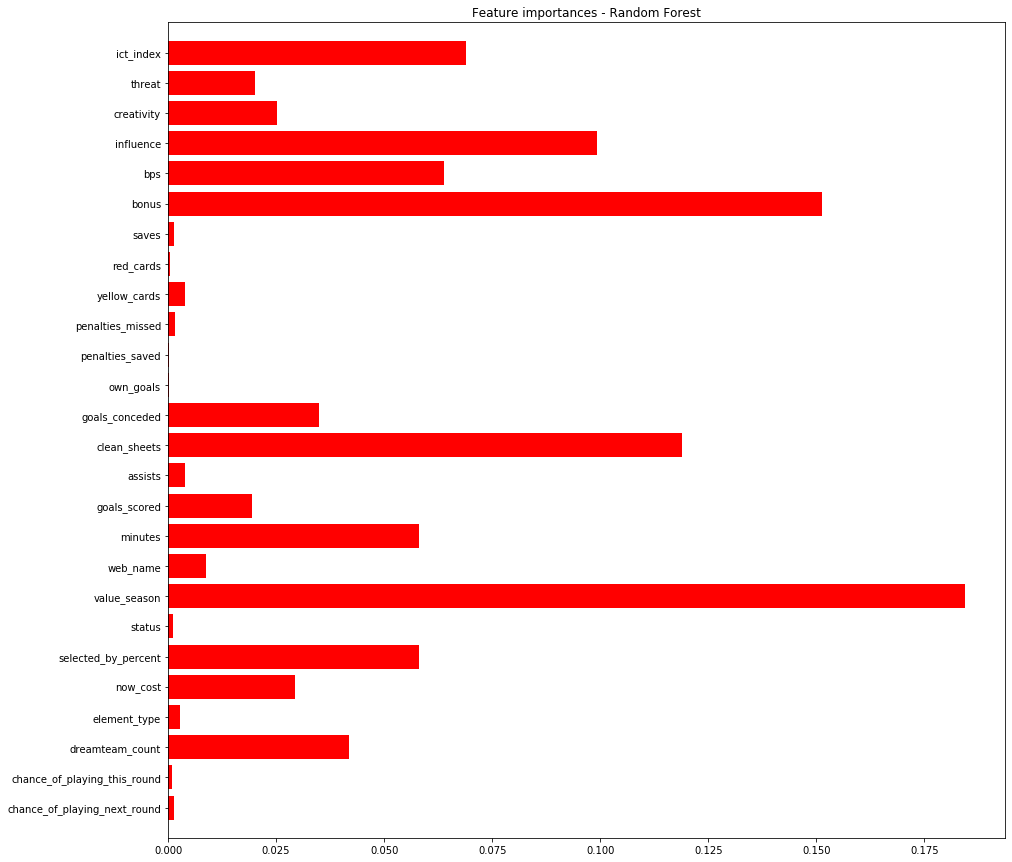

In [52]:
forest = grid.best_estimator_
features = X.columns

plt.figure(figsize=(15,15))
plt.title("Feature importances - Random Forest")
plt.barh(range(X.shape[1]), forest.feature_importances_,
        color="r", align="center")
plt.yticks(range(X.shape[1]), features)
plt.ylim([-1, X.shape[1]])
plt.show()

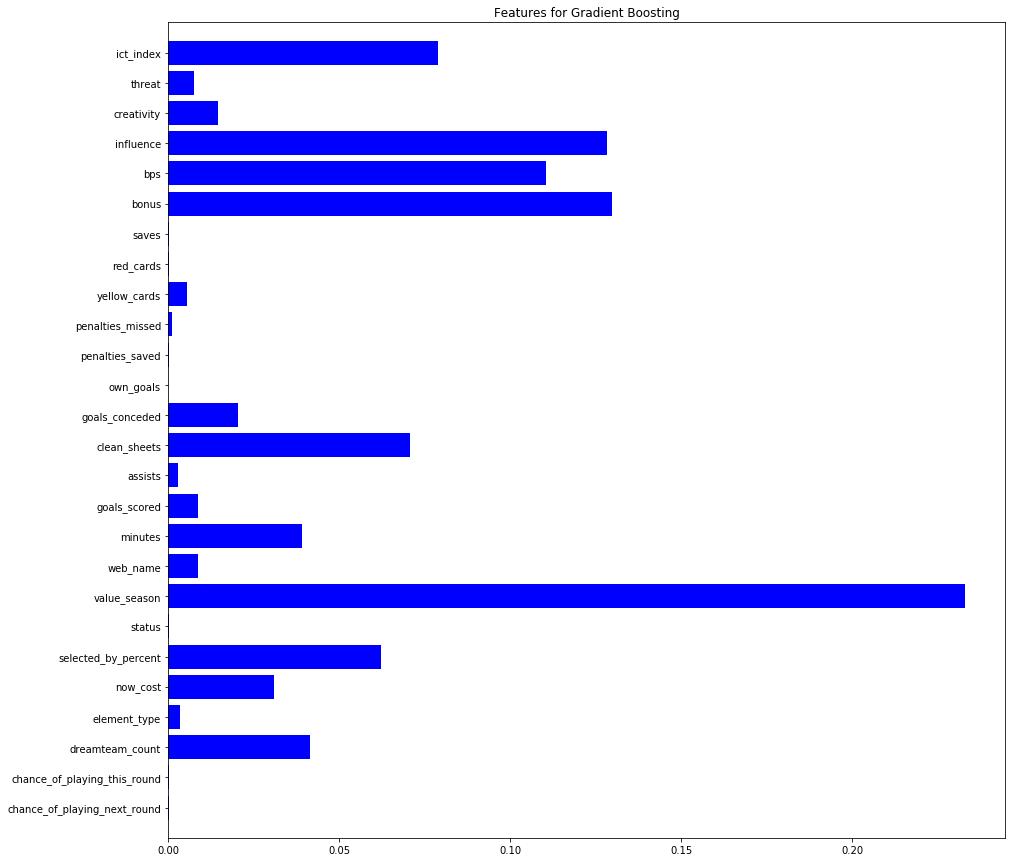

In [53]:
gb = grid1.best_estimator_
plt.figure(figsize = (15,15))
plt.title("Features for Gradient Boosting")
plt.barh(range(len(features)), gb.feature_importances_,
              color='b', align = "center")
plt.yticks(range(len(features)),features)
plt.ylim([-1,X.shape[1]])
plt.show()

## Okay, both are graphs for feature importances are quite different. We do see some similar behaviour but still the result
# is quite different than what I expected.

# Feature Engineering

## Null Values have been taken care of.
## Discard/review variables with low variation


In [54]:
cv =  lambda x: np.std(x) / np.mean(x)
var = np.apply_along_axis(cv, axis=0, arr=X.values)
print(var)

## Setting threshold to 0.3 or 0.5, we get indices 3,4 columns
X.columns

[0.85405814 0.88248812 2.13295725 0.33482178 0.23798964 2.39193713
 2.15717965 0.96957724 0.57676317 0.95856905 2.15540128 1.76730696
 1.1647734  0.9757858  4.91121166 7.52817836 6.56934167 1.32181712
 4.35814977 5.07956495 1.60681073 1.02239013 1.0495782  1.44265826
 1.59067352 1.15095206]


Index(['chance_of_playing_next_round', 'chance_of_playing_this_round',
       'dreamteam_count', 'element_type', 'now_cost', 'selected_by_percent',
       'status', 'value_season', 'web_name', 'minutes', 'goals_scored',
       'assists', 'clean_sheets', 'goals_conceded', 'own_goals',
       'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards',
       'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat',
       'ict_index'],
      dtype='object')

In [55]:
# element_type could be important for our dataset. Also, it is a categorical variable and was ignored above. Let us one hot
# encode it and check the results again
print(X['element_type'].unique())

#Also, dropping cost column, as it would not have very high effect on the points. 
X.drop('now_cost', axis = 1, inplace = True)

[2 4 1 3]


In [56]:
x_temp = pd.get_dummies(X['element_type'], drop_first = True)
print(x_temp)

X['Defender'] = x_temp[2]
X['Midfielder'] = x_temp[3]
X['Forward'] = x_temp[4]

X.drop('element_type', axis = 1, inplace = True)

     2  3  4
0    1  0  0
1    1  0  0
2    1  0  0
3    1  0  0
4    1  0  0
..  .. .. ..
623  0  1  0
624  1  0  0
625  1  0  0
626  0  1  0
627  0  1  0

[628 rows x 3 columns]


In [57]:
cv =  lambda x: np.std(x) / np.mean(x)
var = np.apply_along_axis(cv, axis=0, arr=X.values)
print(var)

# This is much better result than before

[0.85405814 0.88248812 2.13295725 2.39193713 2.15717965 0.96957724
 0.57676317 0.95856905 2.15540128 1.76730696 1.1647734  0.9757858
 4.91121166 7.52817836 6.56934167 1.32181712 4.35814977 5.07956495
 1.60681073 1.02239013 1.0495782  1.44265826 1.59067352 1.15095206
 1.41084237 1.18580364 2.5104433 ]


## Pairwise Correlations

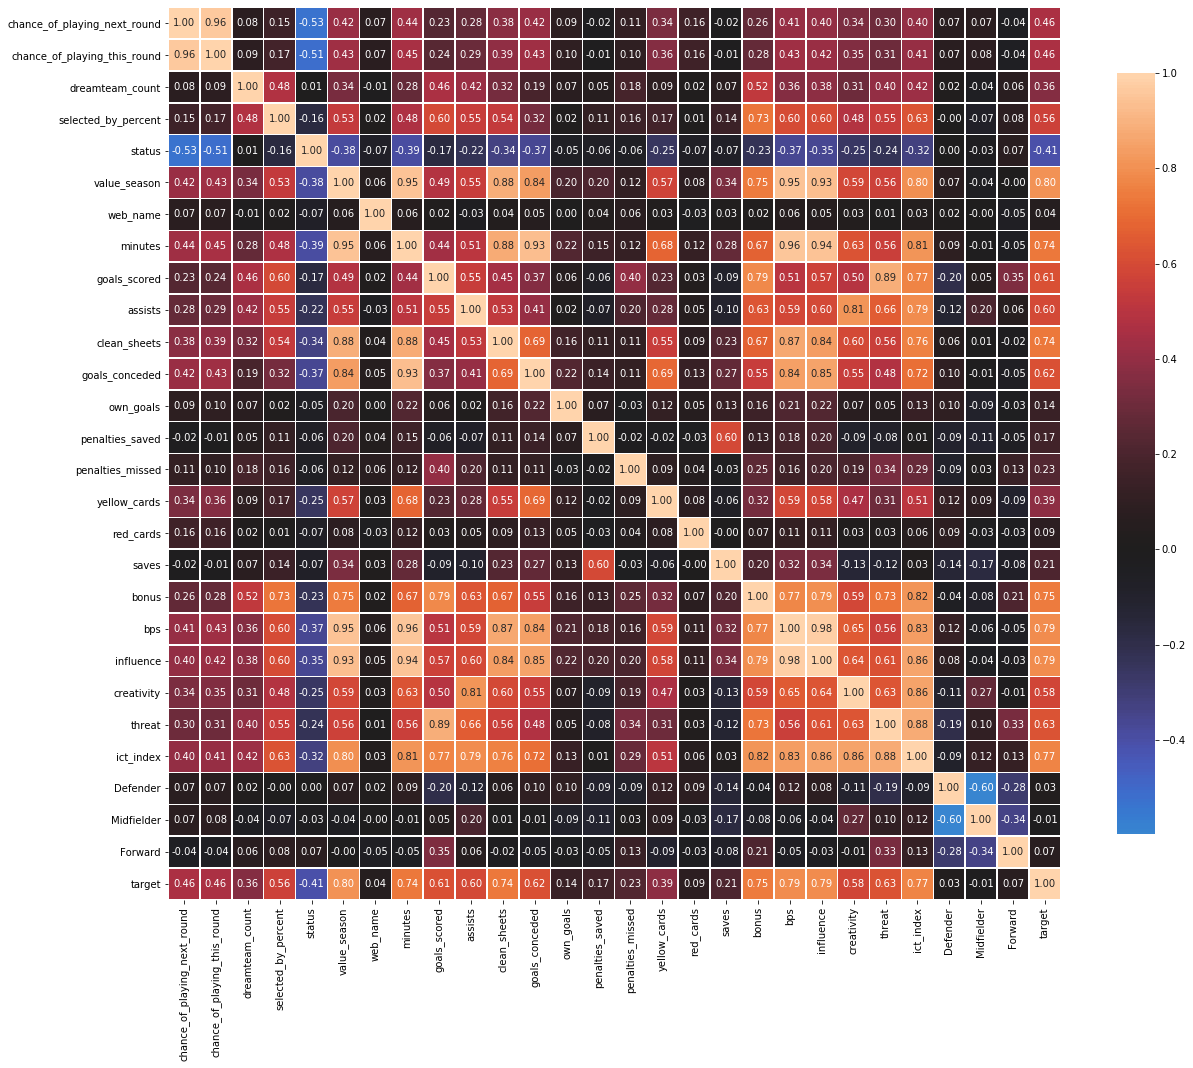

In [58]:
# Adding the target variable back to our dataset for a nice correlation graph
X['target'] = y
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(20,20))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(X)

In [59]:
# Keeping threshold at 0.9

# As we can see that chance of playing next round and this round is perfectly correlated. So we will average them out
# convert to single column 'Chance of playing'

X['chance'] = (X['chance_of_playing_next_round'] + X['chance_of_playing_this_round'])/2
X.drop(['chance_of_playing_next_round','chance_of_playing_this_round'], axis=1, inplace = True)

# Also, we see that Value Season is perfectly correlated to minutes played,bps,influence and these attributes are not 
# similar values that can be averaged out. We will be keeping the variables that have best correlation with target variable.

# Thus, value_season will be kept in between minutes played,bps and influence
X.drop(['influence','bps','minutes'], axis=1, inplace=True)

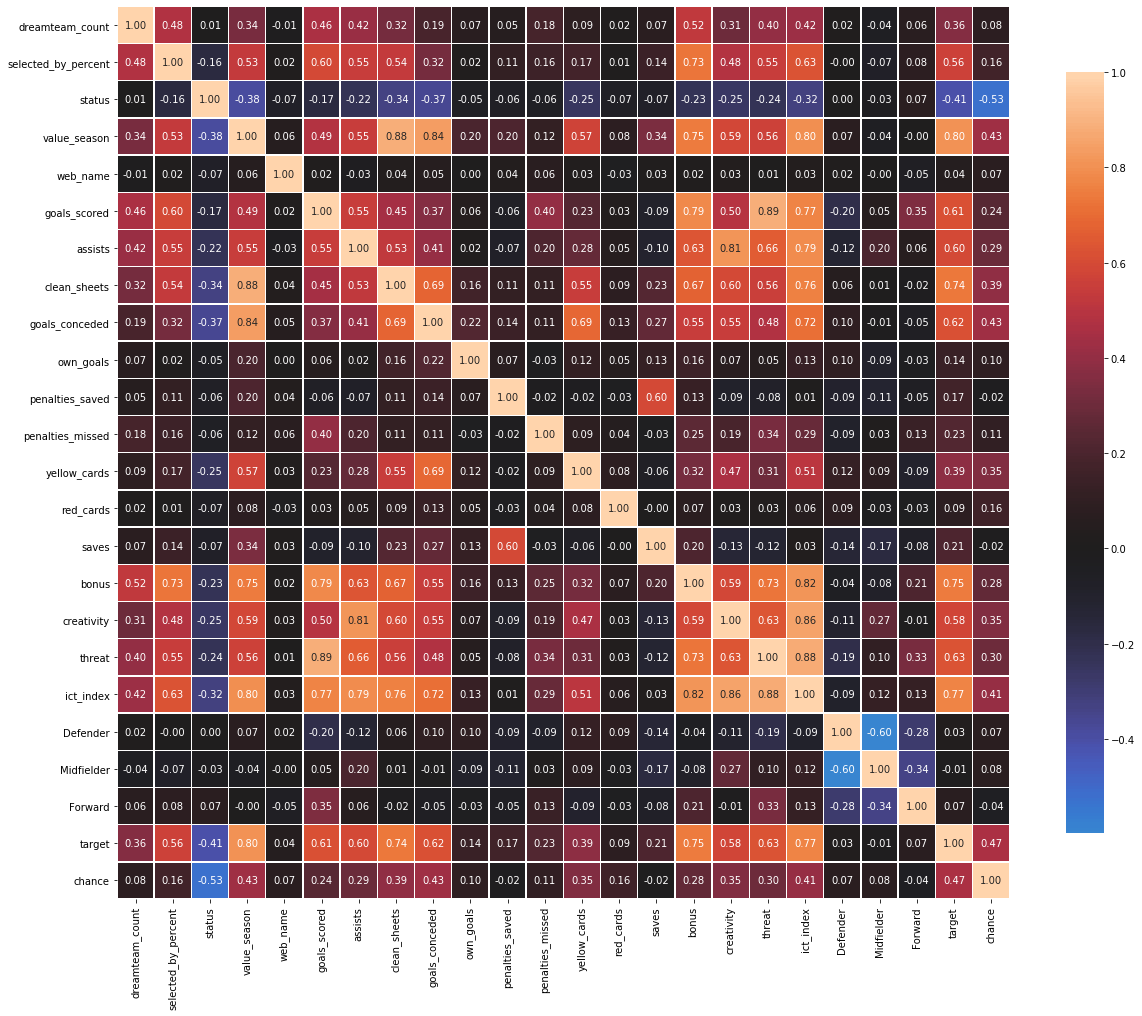

In [60]:
# Lets draw the correlation heatmap again
correlation_heatmap(X)

# Keeping our threshold at 0.80

# Now, we can see that ict_index is correlated to multiple columns which are not correlated with each other. We should drop
# ict_index and we will see significant drop in correlation.

# In pair, Threat vs Goal Scored, Threat is better. Hence, dropping Goal Scored

# Assists vs Creativity, it is slightly higher than our threshold and both have similar effect on target variable.
# If we check their correlation with other variables, creativity has lower correlation so we keep it.

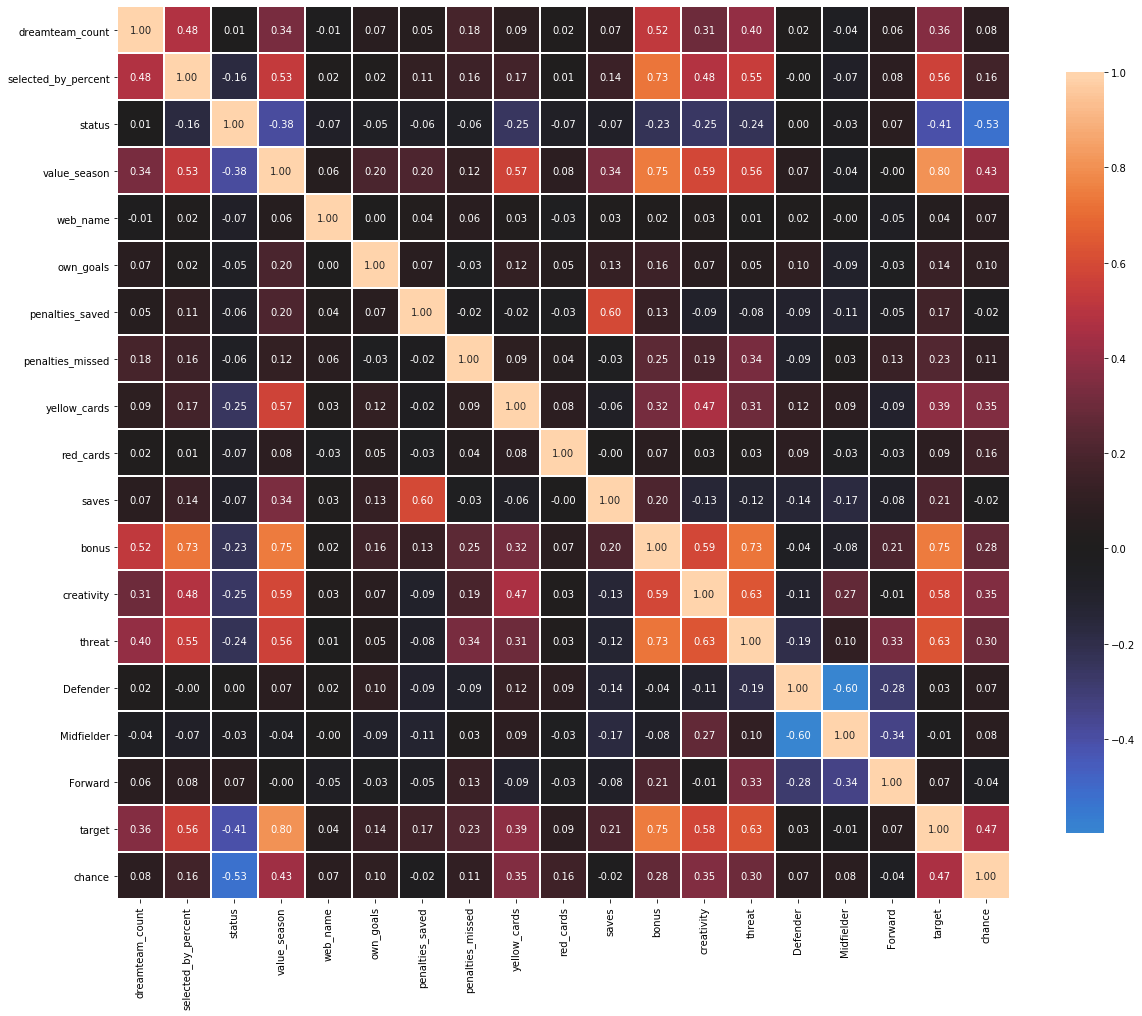

In [61]:
X.drop(['ict_index','goals_scored','assists','goals_conceded','clean_sheets'], axis=1, inplace=True)
correlation_heatmap(X)

In [65]:
## Lets apply our ML models now for or clean dataset. And afterwards we will use Demension Reduction Techinques to get to
# check our performance for that dataset.

## Okay, so here I same models as above because I want to compare the performance of the models on the dataset after feature
# processing. I did make a function earlier to generalize but I realized that the first dataset had every high no. of columns
# and this one does not. So, if I use the same models as above, it should be fine for Linear Regression but my tree based
# models will be hampered a lot and start to overfit. Hence, new models.

X, y = X.drop('target', axis = 1), X.target

cv = KFold(n_splits=5, shuffle = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)
params = {'max_depth': [6,8,10,12], 'max_features' : ['sqrt','log2',6]}
param_gb = {'max_depth': [6,8,10,12], 'max_features' : ['sqrt','log2',6], 'learning_rate': [0.1,0.2]}

grid = GridSearchCV(RandomForestRegressor(random_state = 42),param_grid = params,
                    cv=cv,return_train_score=False).fit(X_train, y_train)

linear = LinearRegression().fit(X_train, y_train)

grid1 = GridSearchCV(GradientBoostingRegressor(), param_grid = param_gb,
                     cv=cv, return_train_score = False).fit(X_train, y_train)


print("Training Score (Linear Regression) : ",linear.score(X_train, y_train))
print("Testing Score : ",linear.score(X_test,y_test))

print("Random Forest Best params - ", grid.best_params_)
print("Training Score (Random Forest) : ",grid.best_score_)
print("Test Score (Unseen Data) :", grid.score(X_test,y_test))

print("Gradient Boost Best params - ", grid1.best_params_)
print("Training Score (Gradient Boost) : ",grid1.best_score_)
print("Test Score (Unseen Data) :", grid1.score(X_test,y_test))


Training Score (Linear Regression) :  0.7638809568950201
Testing Score :  0.6909344519489435
Random Forest Best params -  {'max_depth': 8, 'max_features': 'sqrt'}
Training Score (Random Forest) :  0.8496079855701695
Test Score (Unseen Data) : 0.8534433865632152
Gradient Boost Best params -  {'learning_rate': 0.2, 'max_depth': 6, 'max_features': 6}
Training Score (Gradient Boost) :  0.8612320230233118
Test Score (Unseen Data) : 0.8708119014234478


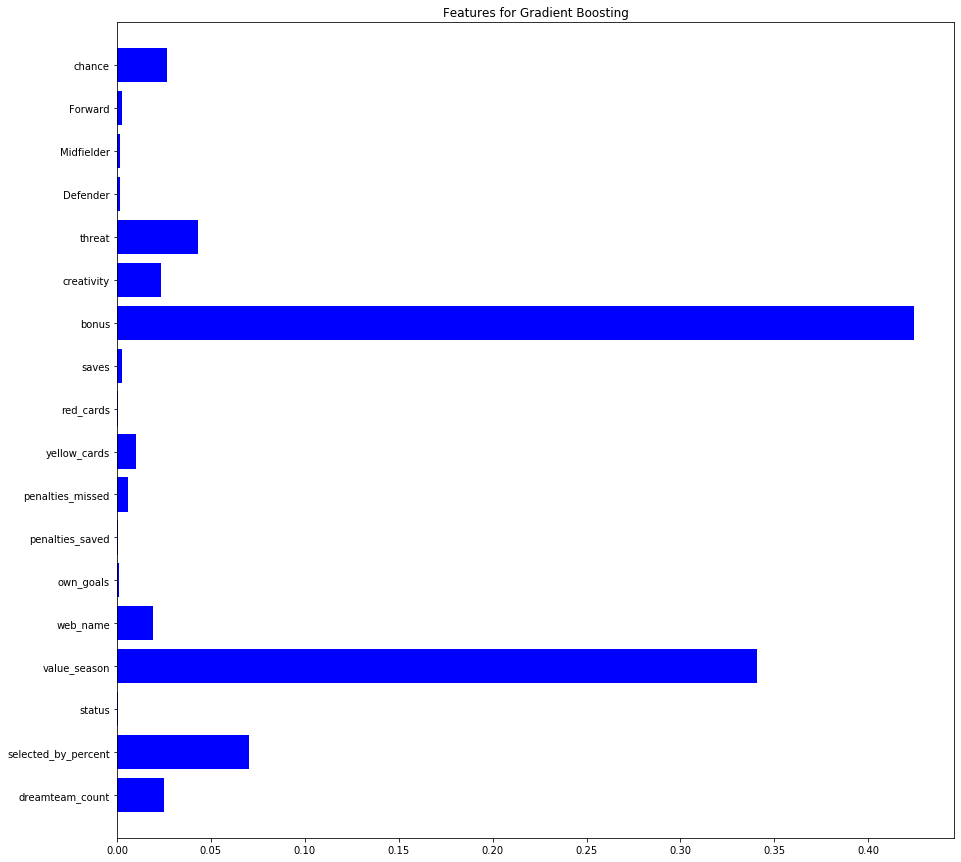

In [66]:
## Observations

#1. Linear Regression is not a good fit for this dataset. That is for sure. The drop in information has clearly affected the
# model for worse. Also, the ratio is kind of same that we saw earlier. With Training score - .8 and test of .76 in full dataset
# I would say that now it has worsen. Maybe if we try to run Ridge Regression on this dataset and Lasso on the full dataset,
# we'll probably get a better result.

#2. Performance for Random Forest is kind of same. The earlier model gave train score = 0.878 and test score of 0.881 and this,
# dataset does drop in performance but it is not a significant drop. Although, accuracy does drop and the new model is almost
# similar in computation as well. So I think I would prefer the first one over this in case of Random Forest.

#3. Gradient Boosting is a little more interesting. The model does drop in performance with the last model giving scores of 
# 0.882 and 0.878 in training and testing respectively. But, our new model generalizes better than the last one.
# The drop in performance is kind of expected because of a lot of data loss. Plus our new GB model is clearly more efficient
# than our last one which was pretty efficient to begin with. I think I would like keep Gradient Boosting as an option for this
# dataset, mainly for the generalizing purpose. I think, if we improve our dataset a little, we could get the same level of performance
# with better generalization of the model.


# Lets see the feature importance graph for GB to compare with previous.

features = X.columns

gb = grid1.best_estimator_
plt.figure(figsize = (15,15))
plt.title("Features for Gradient Boosting")
plt.barh(range(len(features)), gb.feature_importances_,
              color='b', align = "center")
plt.yticks(range(len(features)),features)
plt.ylim([-1,X.shape[1]])
plt.show()


## Correlation with Target

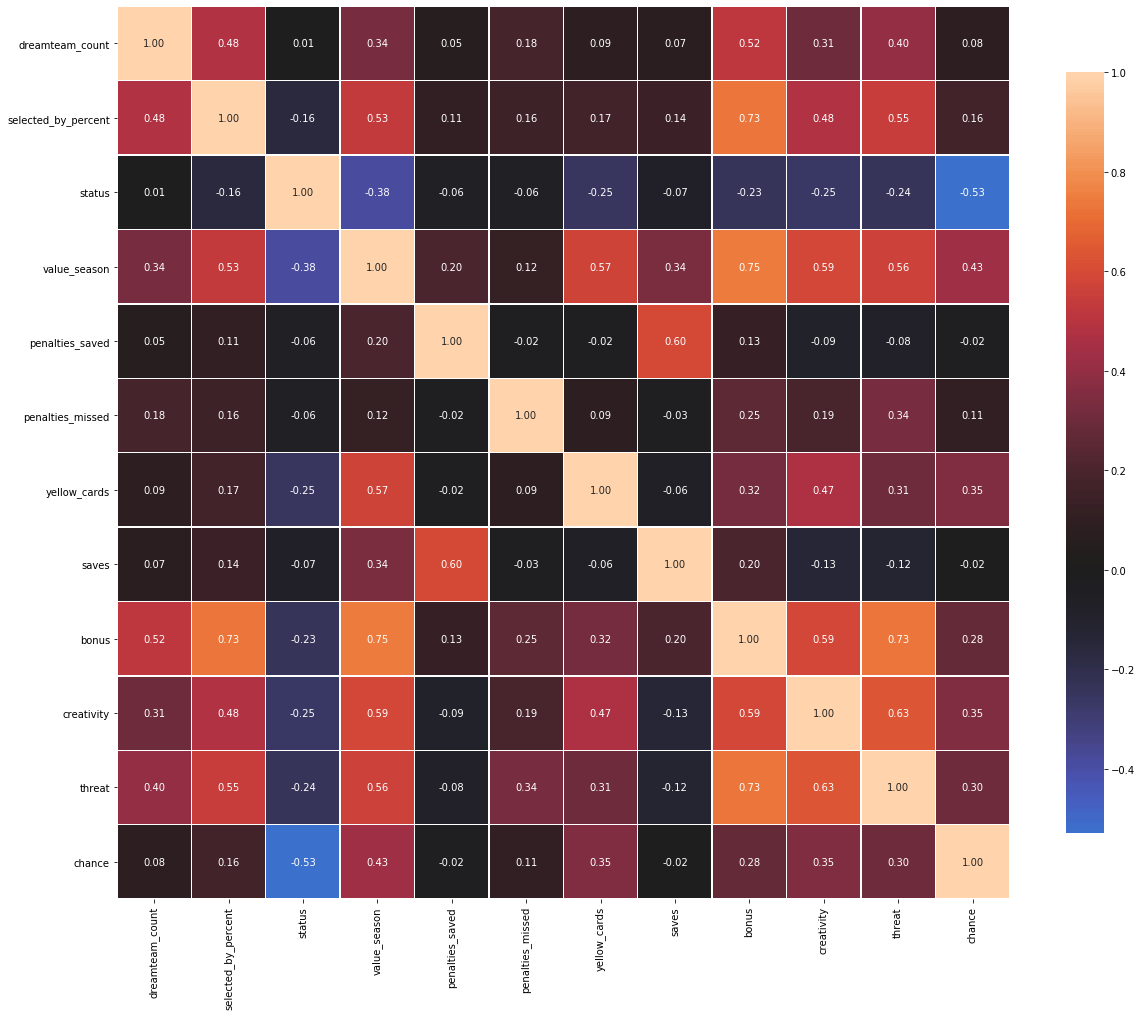

In [67]:
# Threshold = 0.2, any column lower than this would be discarded.

X_relation = X.drop(['web_name','own_goals','red_cards','Defender','Midfielder','Forward'], axis=1)
correlation_heatmap(X_relation)

In [71]:

cv = KFold(n_splits=5, shuffle = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)
params = {'max_depth': [6,8,10,12], 'max_features' : ['sqrt','log2',6]}
param_gb = {'max_depth': [6,8,10,12], 'max_features' : ['sqrt','log2',6], 'learning_rate': [0.1,0.2]}

grid = GridSearchCV(RandomForestRegressor(random_state = 42),param_grid = params,
                    cv=cv,return_train_score=False).fit(X_train, y_train)

linear = LinearRegression().fit(X_train, y_train)

grid1 = GridSearchCV(GradientBoostingRegressor(), param_grid = param_gb,
                     cv=cv, return_train_score = False).fit(X_train, y_train)


print("Training Score (Linear Regression) : ",linear.score(X_train, y_train))
print("Testing Score : ",linear.score(X_test,y_test))

print("Random Forest Best params - ", grid.best_params_)
print("Training Score (Random Forest) : ",grid.best_score_)
print("Test Score (Unseen Data) :", grid.score(X_test,y_test))

print("Gradient Boost Best params - ", grid1.best_params_)
print("Training Score (Gradient Boost) : ",grid1.best_score_)
print("Test Score (Unseen Data) :", grid1.score(X_test,y_test))



Training Score (Linear Regression) :  0.7638809568950201
Testing Score :  0.6909344519489435
Random Forest Best params -  {'max_depth': 12, 'max_features': 6}
Training Score (Random Forest) :  0.8438188017154626
Test Score (Unseen Data) : 0.8610309919990264
Gradient Boost Best params -  {'learning_rate': 0.1, 'max_depth': 6, 'max_features': 'log2'}
Training Score (Gradient Boost) :  0.8578793298575121
Test Score (Unseen Data) : 0.8598198202542067


In [228]:
from sklearn.metrics import accuracy_score

tree.score(X_test,y_test)

0.9976226392926996

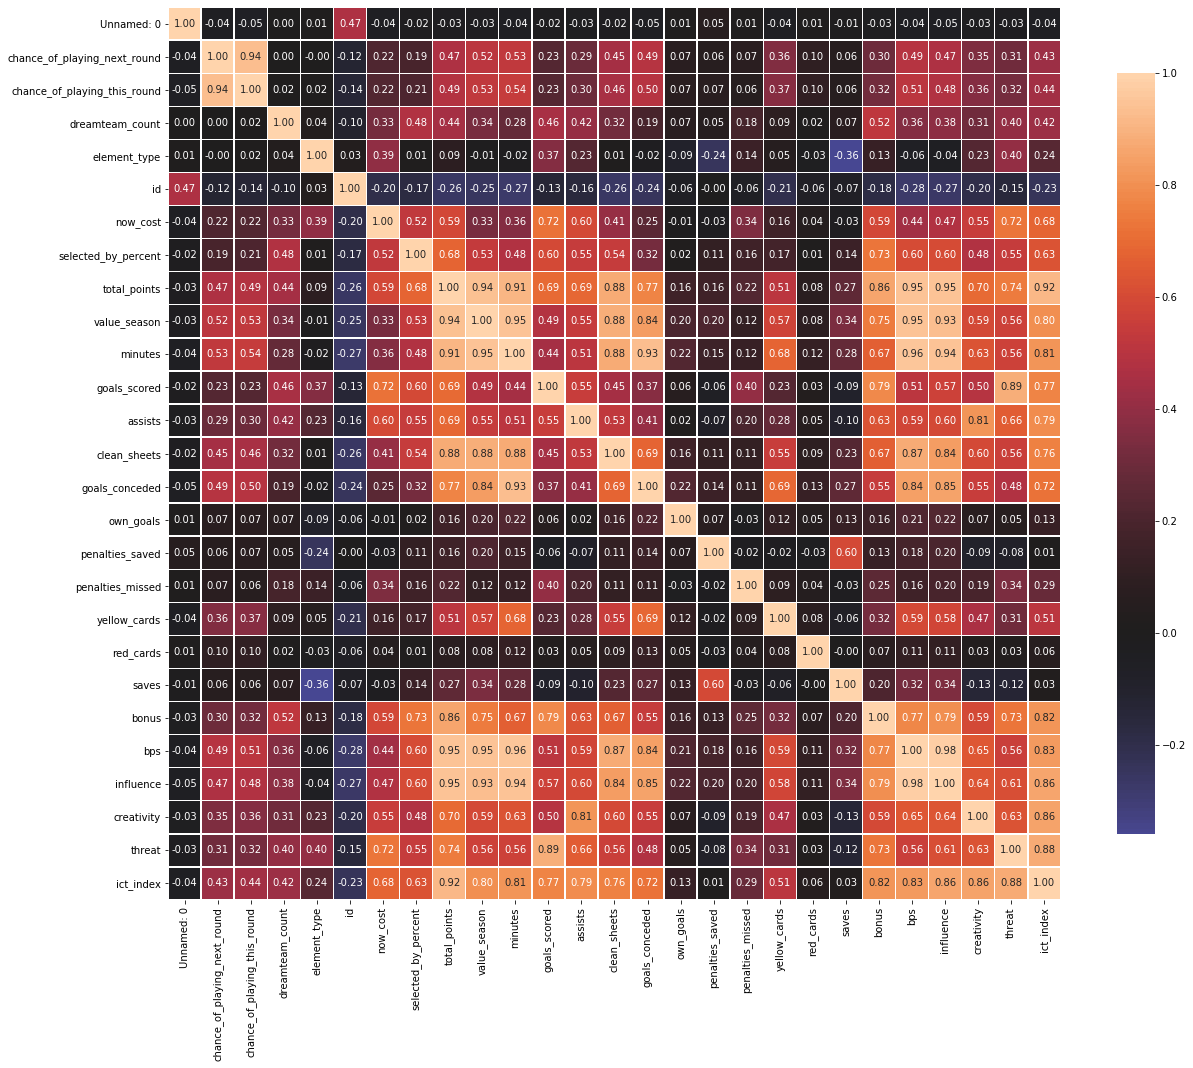

In [132]:
# Here, we see a highly correlated dataset. Lets better represent it

def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(20,20))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(players)


In [133]:
## Here, we will be using the same dataset, just with different target variable and see how it affects the collinearity
# Performing all operations which are similar

df_ppg = pd.read_csv('Players_ppg.csv')
X1, y1= df_ppg.drop(['points_per_game','Unnamed: 0','total_points'], axis=1), df_ppg.points_per_game
X1.columns.shape
X1['chance'] = (X1['chance_of_playing_next_round'] + X1['chance_of_playing_this_round'])/2
X1.drop(['chance_of_playing_next_round','chance_of_playing_this_round'], axis=1, inplace = True)

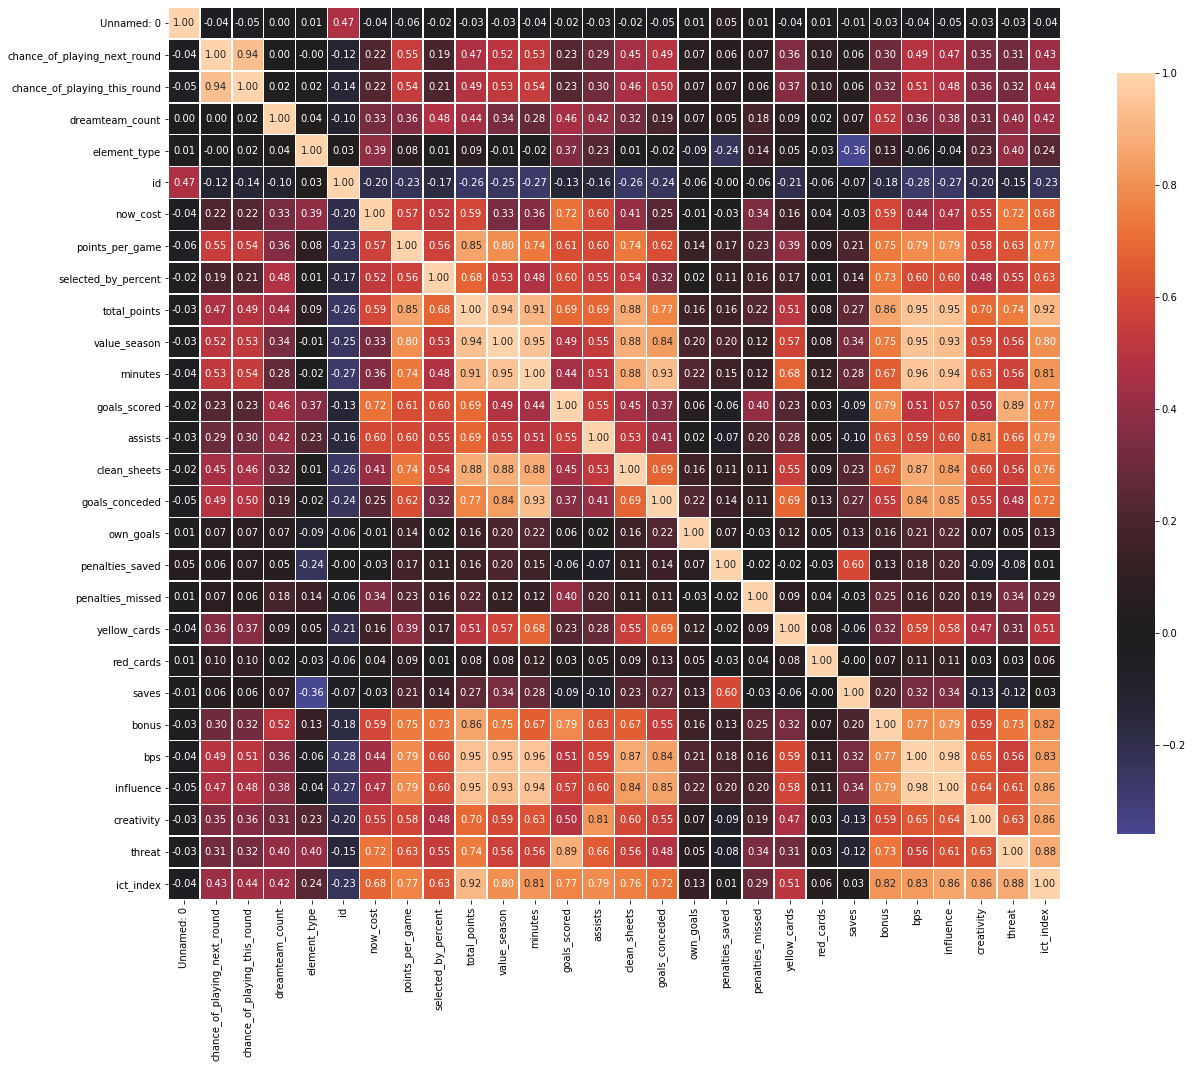

In [141]:
correlation_heatmap(df_ppg)

## This is a better dataset. We can clearly see that points per game metric is less collinear with other variables 
# unlike, total points. And essentially this is the same metric, just averaged out over the gameweeks.

# Also, we can see that element_type has very low collinearity with both the target variables. So can drop it. Since its 
# a string, its not worth making extra columns and converting this variable to boolean data
X.set_index('web_name')
X1.set_index('web_name')

X.drop('element_type', axis = 1, inplace=True)
X1.drop('element_type', axis = 1, inplace=True)

In [143]:
# First things first, we have some very high collinear columns causing multicollinearity in the first datset. 
# Hence, first we scale and combine them together.
# We could also use PCA here, but that leads to data loss. We will use PCA at the end to show the difference.


X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state = 42)

# Scaling the dataset
from sklearn.preprocessing import StandardScaler

s1 = StandardScaler().fit(X_train)
X_train_scaled = s1.transform(X_train)
X_test_scaled  = s1.transform(X_train)

s2 = StandardScaler().fit(X1_train)
X1_train_scaled = s2.transform
X1_test_scaled = s2.transform(X1_train)

ValueError: could not convert string to float: 'a'

In [ ]:
# We have our datasets. Normally, we would be scaling our data, using PCA over it to reduce dimensions, 
# drop columns by variation, use cluster analysis and then finally apply Lasso and Tree Based Algorithm 
# to get the best variables.

# We will do all of the above, only thing is we will fit the data to our models at very step to check performance.

from sklearn.model import LinearRegression